In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipystats
from scipy import signal

from utils.neurosuite import get_unit_names_sorted
from utils.psth import get_shuffled, get_spike_counts
from utils.spatial import gaussian_kernel_2D
from utils.spiketrain import smooth_gaussian
from utils.behavior import get_idxs_as_periods
#from utils.events import get_sound_event_periods

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Phase locking in diff states

In [4]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

In [5]:
session = "013608_ppcSIT_2025-01-14_10-20-14"

animal    = session.split('_')[0]
meta_file = os.path.join(source, animal, session, 'meta.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')
unit_file = os.path.join(source, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

with h5py.File(phsl_file, 'r') as f:
    conditions = [x for x in f]
    unit_ids   = [x for x in f[conditions[0]]]
    
spike_times = {}
with h5py.File(unit_file, 'r') as f:
    #units_to_plot = get_unit_names_sorted([name for name in f])
    for unit_name in unit_ids:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

In [6]:
speed_max = 0.04

speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]

# times of first tgt success pulses
idxs_tgt_first_ev = tgt_mx[tgt_mx[:, 4] == 1][:, 0]
tgt_first_t = sound_events[idxs_tgt_first_ev][:, 0]

# success stays
idxs_tgt_succ = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

In [7]:
# MRL
MRL_mx = np.zeros([len(unit_ids), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_ids):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [8]:
# mean firing rate
FR_mx = np.zeros([len(unit_ids), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_ids):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

### Filters

In [9]:
# MRL criteria
pv_min = 0.5
MRL_min = 0.03
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_ids)} units > 0.5Hz firing rate")
    
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198']
}
idxs_special = [unit_ids.index(x) for x in special['013608_ppcSIT_2025-01-14_10-20-14']]
print(f"{len(idxs_special)} units to be excluded as special")


# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)

idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

print(f"{len(idxs_MRL_high)} units with phase locking selected")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")

156 out of 213 units > 0.5Hz firing rate
4 units to be excluded as special
86 units with phase locking selected
34 units have kind of no phase locking


In [10]:
# show exact unit IDs selected
print([unit_ids[x] for x in idxs_MRL_high])

['1-105', '1-107', '1-121', '1-138', '1-147', '1-165', '1-375', '1-38', '1-39', '1-398', '1-409', '1-429', '1-440', '1-441', '1-442', '1-449', '1-450', '1-459', '1-482', '1-95', '2-123', '2-230', '2-244', '2-288', '2-289', '2-328', '2-361', '2-382', '2-410', '2-422', '2-433', '2-434', '2-435', '2-444', '2-468', '2-478', '2-58', '2-84', '2-85', '2-99', '3-118', '3-155', '3-17', '3-18', '3-21', '3-214', '3-235', '3-247', '3-271', '3-280', '3-294', '3-295', '3-296', '3-312', '3-33', '3-331', '3-34', '3-35', '3-367', '3-371', '3-389', '3-404', '3-49', '3-6', '3-62', '3-63', '3-75', '3-87', '3-88', '3-89', '4-186', '4-200', '4-203', '4-212', '4-249', '4-261', '4-262', '4-274', '4-298', '4-299', '4-324', '4-336', '4-338', '4-350', '4-351', '4-372']


### periods of stationarity / running

In [11]:
period_matrices = {}  
min_dur = 4  # in sounds events, 4 events per second
conds = [
    'BGR_long_stays', 
    'BGR_long_runs', 
    'SIL_long_stays',
    'SIL_long_runs',
    'TGT_long_stays',
]
idxs_conds = [
    np.intersect1d(idxs_bgr_ev, idxs_sta_ev),
    np.intersect1d(idxs_bgr_ev, idxs_run_ev),
    np.intersect1d(idxs_sil_ev, idxs_sta_ev),
    np.intersect1d(idxs_sil_ev, idxs_run_ev),
    #np.intersect1d(idxs_tgt_ev, idxs_sta_ev),
    idxs_tgt_ev
]
exclude_l, exclude_r = 2, 1  # number of events


for i, idxs_condition in enumerate(idxs_conds):
    periods_loc_ev = get_idxs_as_periods(idxs_condition)
    periods_filt = periods_loc_ev[np.where(np.diff(periods_loc_ev, axis=1) > min_dur)[0]]

    # don't consider first X and last Y pulses as boundary condition
    periods_filt_ex = []
    for per in periods_filt:
        per_ex = [per[0] + exclude_l, per[1] - exclude_r]
        if per_ex[1] - per_ex[0] > 1:  # at least two pulses
            periods_filt_ex.append(per_ex)
    periods_filt_ex = np.array(periods_filt_ex)

    long_pers_xy = np.zeros([len(periods_filt_ex), 4])
    for k, ls_rec in enumerate(periods_filt_ex):
        idx_tl_s = int(sound_events[ls_rec[0]][2])
        idx_tl_e = int(sound_events[ls_rec[1]][2])
        x_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 1]
        y_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 2]

        long_pers_xy[k] = [ls_rec[0], ls_rec[1], x_pos.mean(), y_pos.mean()]

    period_matrices[conds[i]] = long_pers_xy

# back to indices
idxs_matrices = {}
for cond, mx in period_matrices.items():
    idxs_long_pers_ev = []
    for ls in mx:
        idxs_long_pers_ev += list(np.arange(int(ls[0]), int(ls[1])))
    idxs_matrices[cond] = np.array(idxs_long_pers_ev) # sound_events[idxs_long_pers_ev][:, 0]

In [12]:
for i, (cond, mx) in enumerate(idxs_matrices.items()):
    print(f"{cond}: {mx.shape} out of {len(idxs_conds[i])}")

BGR_long_stays: (715,) out of 1756
BGR_long_runs: (29,) out of 842
SIL_long_stays: (774,) out of 2353
SIL_long_runs: (590,) out of 2172
TGT_long_stays: (971,) out of 1174


## Precession in TGT?

In [14]:
offset = 0.25

unit_pulse_press = {}
for i, unit_id in enumerate(unit_ids):
    spk_times = spike_times[unit_id]
    
    collected = []
    for j, tgt_rec in enumerate(tgt_mx[tgt_mx[:, 4] == 1]):
        t_start = sound_events[tgt_rec[0]][0]
        pulse_idxs = np.arange(tgt_rec[0], tgt_rec[1] + 1)
        for idx_pulse_ev in pulse_idxs:
            t_pulse = sound_events[idx_pulse_ev][0]
            selected = spk_times[(spk_times > t_pulse) & (spk_times < t_pulse + offset)]
            collected += [[x - t_start, x - t_pulse] for x in selected]
    unit_pulse_press[unit_id] = np.array(collected)

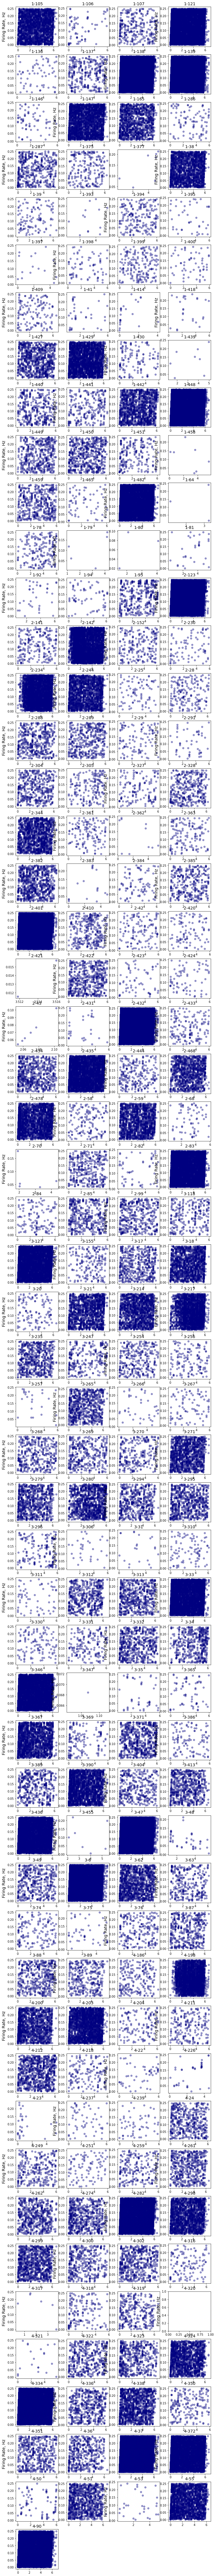

In [21]:
cols = 4
rows = int(np.ceil(len(unit_ids)/cols))
fig = plt.figure(figsize=(3*cols, 3*rows))

for i, unit_id in enumerate(unit_ids):
    ph_p = unit_pulse_press[unit_id]
    
    ax = fig.add_subplot(rows, cols, i+1)
    if len(ph_p) > 0:
        ax.scatter(ph_p[:, 0], ph_p[:, 1], alpha=0.4, color='navy')
    ax.set_title(unit_id, fontsize=14)
    if i % 3 == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)

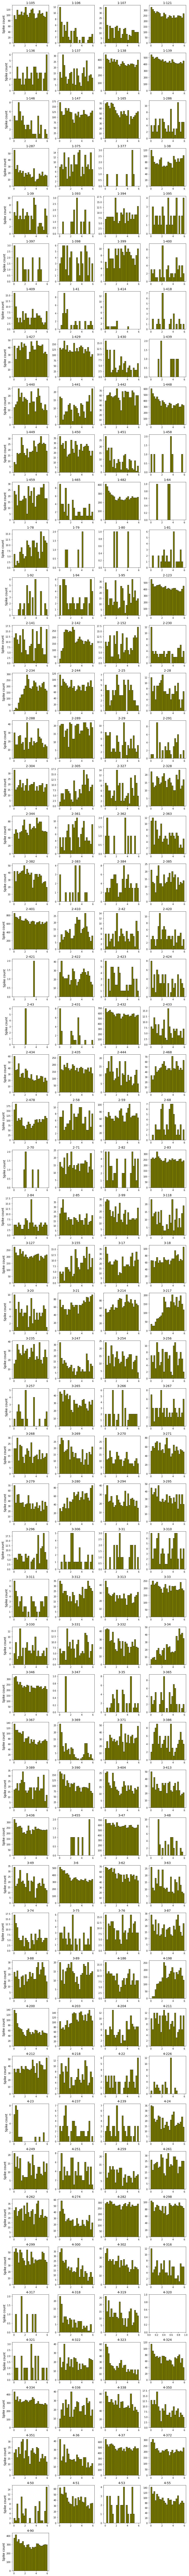

In [29]:
cols = 4
rows = int(np.ceil(len(unit_ids)/cols))
bins = np.arange(0, 6.25, 0.25)

fig = plt.figure(figsize=(3*cols, 3*rows))
for i, unit_id in enumerate(unit_ids):
    ph_p = unit_pulse_press[unit_id]
    
    ax = fig.add_subplot(rows, cols, i+1)
    if len(ph_p) > 0:
        ax.hist(ph_p[:, 0], bins=bins, edgecolor='black', color='olive')
    ax.set_title(unit_id, fontsize=14)
    if i % cols == 0:
        ax.set_ylabel("Spike count", fontsize=14)
fig.tight_layout()